# Launch dask cluster

We first launch a cluster and import it in the notebook, it should look like this :

# Import libraries

We load basic libraries (numpy, xarray, matplotlib) and one more specific :
  - gcm_filters for spatial filtering compatible with xarray : https://gcm-filters.readthedocs.io/en/latest/


In [2]:
import numpy as np
import xarray as xr
import gcm_filters
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

# Call data

We use the catalog to import our dataset

In [3]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

In [4]:
enatl01w = cat.eNATL60(region='1',datatype='surface_hourly', season='fma'
                      ).to_dask()

enatl01w

<xarray.Dataset>
Dimensions:        (y: 763, x: 611, time_counter: 2136)
Coordinates: (12/15)
    depth          (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1t            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1u            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1v            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e2f            (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    ...             ...
    lat            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(72,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
Dimensions without coordinates: y, x
Data variables: (12/13)
    fmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    qt_oce         (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    somecrty       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sometauy       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sosaline       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sossheig       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    ...             ...
    sowaflup       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sozocrtx       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    sozotaux       (time_counter, y, x) float32 dask.array<chunksize=(72, 763, 611), meta=np.ndarray>
    tmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    umask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>
    vmask          (y, x) int8 dask.array<chunksize=(763, 611), meta=np.ndarray>

We will reproduce results similar to [Uchida et al. (2022)](https://gmd.copernicus.org/articles/15/5829/2022/) below.
# Set up variables needed for ${\tt gcm-filters}$
The `wet_mask` defines the land cells and boundaries so that the filtering neglects the masked cells. Otherwise, the default is set so that the boundary conditions are doubly periodic.

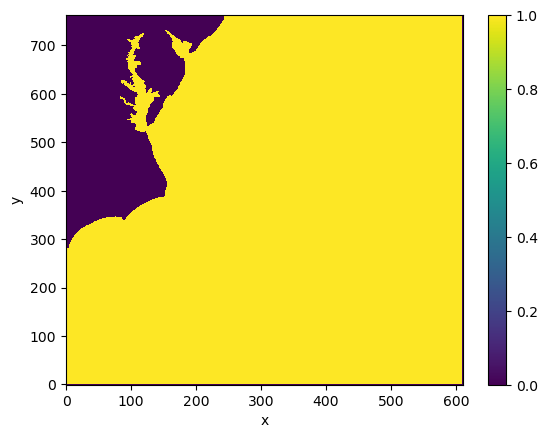

In [5]:
wet_mask = xr.DataArray(np.zeros_like(enatl01w.sosstsst.isel(time_counter=0)),
                        dims=['y','x'],
                        coords={'y':np.arange(len(enatl01w.y)),
                                'x':np.arange(len(enatl01w.x))}
           )
wet_mask[1:-1,1:-1] = enatl01w.tmask[1:-1,1:-1].data.astype(np.float64)

wet_mask.plot()

In [6]:
sst = xr.DataArray(.5*(enatl01w.sosstsst.fillna(0.).data 
                       + enatl01w.sosstsst.fillna(0.).data
                      ),
                   dims=['time_counter','y','x'],
                   coords={'time_counter':enatl01w.time_counter.data, 
                           'y':np.arange(len(enatl01w.y)),
                           'x':np.arange(len(enatl01w.x))}
                  )

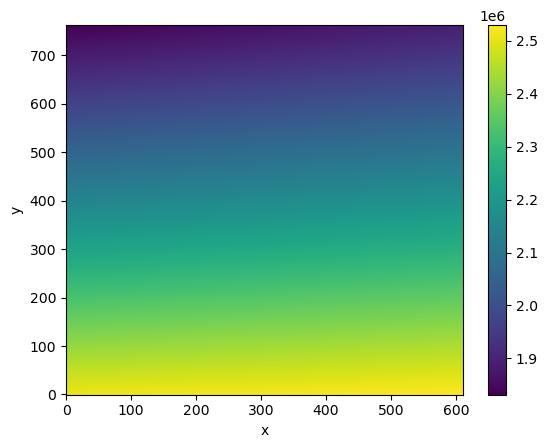

In [7]:
area = (enatl01w.e1t * enatl01w.e2t)

area.plot()

In [8]:
dxw = xr.DataArray(enatl01w.e1u.data, dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y)),
                           'x':np.arange(len(enatl01w.x))}
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(enatl01w.e2u.data, dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y)),
                           'x':np.arange(len(enatl01w.x))}
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(enatl01w.e1v.data, dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y)),
                           'x':np.arange(len(enatl01w.x))}
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(enatl01w.e2v.data, dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y)),
                           'x':np.arange(len(enatl01w.x))}
                  ) # y-spacing centered at southern cell edge
dxw

<xarray.DataArray 'open_dataset-9bebf7a89728bfddf8d6d8c832230e80e1u-dce8985b0e2027bc76d06105d6839a82' (
                                                                                                       y: 763,
                                                                                                       x: 611)>
dask.array<open_dataset-9bebf7a89728bfddf8d6d8c832230e80e1u, shape=(763, 611), dtype=float64, chunksize=(763, 611), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 754 755 756 757 758 759 760 761 762
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 602 603 604 605 606 607 608 609 610

In [9]:
dx_min = min(enatl01w.e1u.min(['y','x']), enatl01w.e2u.min(['y','x']),
             enatl01w.e1v.min(['y','x']), enatl01w.e2v.min(['y','x'])
            )
dx_min = dx_min.values
dx_min

array(1289.18071484)

In [10]:
kappa_w = xr.zeros_like(wet_mask)
kappa_w[1:-1,1:-1] += 1.
kappa_s = xr.zeros_like(wet_mask)
kappa_s[1:-1,1:-1] += 1.

In [11]:
filter_scale = 30000   # 30 km

filter_30km = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    # n_steps=36,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.chunk({'y':-1,'x':-1}), 
        'dxw': dxw.chunk({'y':-1,'x':-1}), 'dyw': dyw.chunk({'y':-1,'x':-1}), 
        'dxs': dxs.chunk({'y':-1,'x':-1}), 'dys': dys.chunk({'y':-1,'x':-1}), 
        'area': area.chunk({'y':-1,'x':-1}), 
        'kappa_w': kappa_w.chunk({'y':-1,'x':-1}), 'kappa_s': kappa_s.chunk({'y':-1,'x':-1})
    }
)

filter_30km

Filter(filter_scale=30000, dx_min=array(1289.18071484), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=26, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

# Filter SST

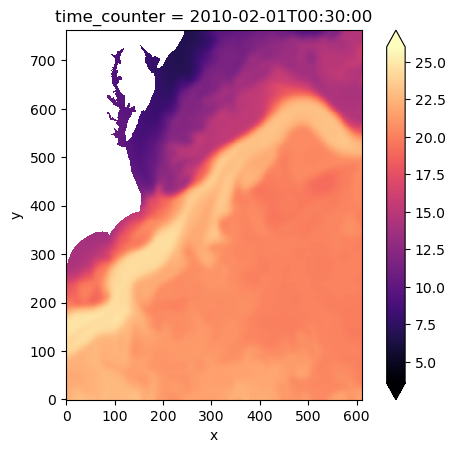

In [12]:
sst_filtered_to_30km = filter_30km.apply(sst.chunk({'y':-1,'x':-1}), dims=['y', 'x'])

fig, ax = plt.subplots()
(sst_filtered_to_30km.where(enatl01w.tmask!=0.).isel(time_counter=0)
).plot(vmax=4,vmin=26,cmap='magma',ax=ax)
ax.set_aspect('equal')

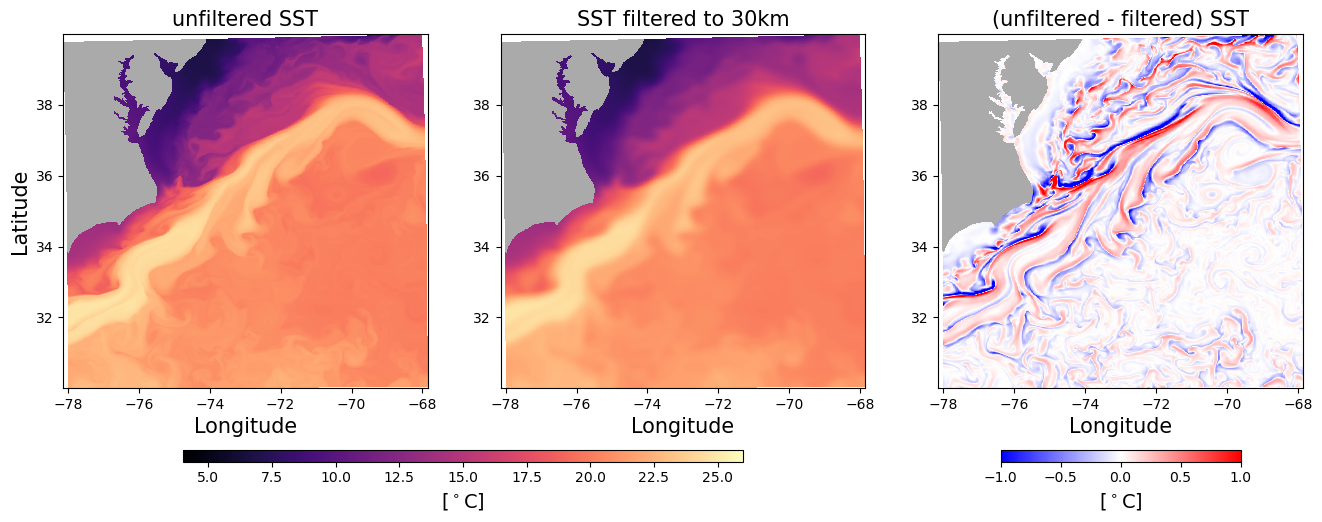

In [13]:
vmin = 4
vmax = 26

fig, axs = plt.subplots(1,3,figsize=(16,6))

im = axs[0].pcolormesh(enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)), 
                       enatl01w.lat.isel(y=slice(1,-1),x=slice(1,-1)),
                       sst.where(enatl01w.tmask!=0.).isel(time_counter=0, 
                                                          y=slice(1,-1),x=slice(1,-1)), 
                       vmin=vmin, vmax=vmax, 
                       cmap='magma', 
#                        cbar_kwargs={'label': r'm d$^{-1}$'},
                       shading='auto', rasterized=True
)
axs[0].set_title('unfiltered SST', fontsize=15)

axs[1].pcolormesh(enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)), 
                  enatl01w.lat.isel(y=slice(1,-1),x=slice(1,-1)),
                  sst_filtered_to_30km.where(enatl01w.tmask!=0.).isel(time_counter=0,
                                                                      y=slice(1,-1),x=slice(1,-1)), 
                  vmin=vmin, vmax=vmax, 
                  cmap='magma', 
#                   cbar_kwargs={'label': r'm d$^{-1}$'}
                  shading='auto', rasterized=True
)
axs[1].set_title('SST filtered to 30km', fontsize=15)

im2 = axs[2].pcolormesh(enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)), 
                        enatl01w.lat.isel(y=slice(1,-1),x=slice(1,-1)),
                        (sst.where(enatl01w.tmask!=0.).isel(time_counter=0) 
                         - sst_filtered_to_30km.where(enatl01w.tmask!=0.).isel(time_counter=0)
                        ).isel(y=slice(1,-1),x=slice(1,-1)), 
                        vmax=1, vmin=-1,
                        cmap='bwr', 
#                   cbar_kwargs={'label': r'm d$^{-1}$'}
                        shading='auto', rasterized=True
)
axs[2].set_title(r'(unfiltered - filtered) SST', fontsize=15);

axs[0].pcolormesh(enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)), 
                  enatl01w.lat.isel(y=slice(1,-1),x=slice(1,-1)), 
                  np.ma.masked_values(enatl01w.tmask.isel(y=slice(1,-1),x=slice(1,-1)), 
                                      1.).astype(np.float64),
                  vmin=-1, vmax=2, cmap='binary', rasterized=True)
axs[1].pcolormesh(enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)), 
                  enatl01w.lat.isel(y=slice(1,-1),x=slice(1,-1)), 
                  np.ma.masked_values(enatl01w.tmask.isel(y=slice(1,-1),x=slice(1,-1)), 
                                      1.).astype(np.float64),
                  vmin=-1, vmax=2, cmap='binary', rasterized=True)
axs[2].pcolormesh(enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)), 
                  enatl01w.lat.isel(y=slice(1,-1),x=slice(1,-1)), 
                  np.ma.masked_values(enatl01w.tmask.isel(y=slice(1,-1),x=slice(1,-1)), 
                                      1.).astype(np.float64),
                  vmin=-1, vmax=2, cmap='binary', rasterized=True)

axs[0].set_ylabel(r"Latitude", fontsize=15)
axs[0].set_xlabel(r"Longitude", fontsize=15)
axs[1].set_xlabel(r"Longitude", fontsize=15)
axs[2].set_xlabel(r"Longitude", fontsize=15)

axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
axs[2].set_aspect('equal')

fig.subplots_adjust(bottom=0.255, hspace=.2)
cbaxes = fig.add_axes([0.2, 0.15, 0.35, 0.019]) 
cbar = fig.colorbar(im, orientation='horizontal', cax=cbaxes,
#                     ticks=[-2.8,-2.1,-1.4,-.7,0.,.7,1.4,2.1,2.8]
                   )
cbaxes2 = fig.add_axes([0.711, 0.15, 0.15, 0.019]) 
cbar2 = fig.colorbar(im2, orientation='horizontal', cax=cbaxes2,
#                     ticks=[-2.8,-2.1,-1.4,-.7,0.,.7,1.4,2.1,2.8]
                    )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r'[$^\circ$C]', fontsize=14)
cbar2.set_label(r'[$^\circ$C]', fontsize=14)